In [84]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.11.0'

## Carregamento e pré-processamento da base de dados

In [85]:
(X_treinamento, y_treinamento), (_,_) = tf.keras.datasets.mnist.load_data()
# Quando trabalhamos com GANs, o objetivo é apenas gerar novas imagens
# Não importando o X e y de teste

In [86]:
X_treinamento.shape #60000 registros com imagens de 28x28 pixels em escala de cinza

(60000, 28, 28)

In [87]:
28 * 28

784

In [88]:
y_treinamento.shape #contem os digitos de 0 a 9

(60000,)

6


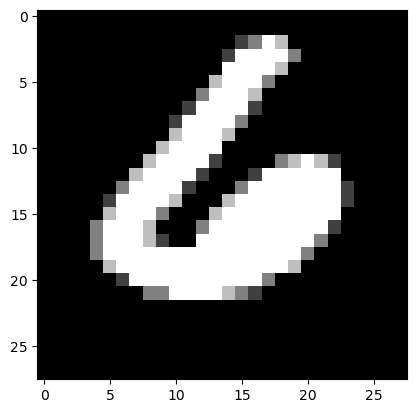

In [89]:
i = np.random.randint(0, 60000)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap='gray')

In [90]:
#Adicionando mais uma dimensão à imagem indicando o número de canais
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32') 

In [91]:
X_treinamento.shape

(60000, 28, 28, 1)

In [92]:
#Exibindo os valores mínimos e máximos da primeira imagem 
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [93]:
# Se tratando de normalização em GANs, recomenda-se que os valores estejam entre -1 e 1
# Pois os resultados tendem a ser melhores
X_treinamento = (X_treinamento - 127.5) / 127.5

In [94]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [95]:
buffer_size = 60000
batch_size = 256 #mini batch gradient descent

In [96]:
buffer_size / batch_size 

234.375

In [97]:
type(X_treinamento)

numpy.ndarray

In [98]:
#Convertendo o numpy array para uma variável no formato do tensorflow
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

2023-02-17 20:15:13.656911: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


In [99]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [100]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Construção do gerador

In [101]:
7*7*256 #número de neurônios na primeira camada oculta

12544

In [102]:
# Gerador recebe uma quantidade finita de numeros aleatórios, e no final gera uma imagem
# neurônios de entrada = 100 pois a rede receberá 100 números aleatórios
# 100 -> 12544
# Valores definidos de acordo com a documentação do Tensorflow
def cria_gerador():
    network = tf.keras.Sequential()
    
    network.add(layers.Dense(7*7*256, use_bias=False,input_shape=(100,)))
    network.add(layers.BatchNormalization()) #A ideia dessa camada é normalizar os valores da camada oculta
    network.add(layers.LeakyReLU()) #Função de ativação similar à ReLU
    
    network.add(layers.Reshape((7,7,256))) #Transformando a matriz em um tensor
    
    # 7x7x128
    #O Conv2D reduz a dimensionalidade, já o Conv2DTranspose aumenta
    network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False)) 
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    #14x14x64
    network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2))) 
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    #28x28x1
    network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))
    
    network.summary()
    
    return network


In [103]:
gerador = cria_gerador()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 128)       

In [104]:
gerador.input #100 = número de valores aleatórios que a camada de entrada vai receber

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_4_input')>

In [105]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.7965879 , -0.21093632, -0.40354088,  1.5061715 ,  0.37617192,
         0.00997091, -0.7436145 , -0.6583105 , -1.6308978 , -0.35592875,
        -0.05839777, -1.9050558 , -0.33653307, -1.1121858 , -0.10667225,
         1.6555731 , -0.06991405,  0.26910034, -1.9739212 ,  1.4893894 ,
        -0.77864194, -1.5697114 ,  0.10928135,  0.68905395,  1.064864  ,
         0.8338615 , -1.0732145 ,  0.444593  , -0.4591149 ,  1.6197572 ,
         1.2859994 , -0.60265106,  0.29779994,  1.839681  ,  1.1360091 ,
        -0.82963204,  0.6560583 , -0.25410375,  0.9444558 ,  0.16499673,
         0.9930687 ,  0.77438337,  2.3718772 , -0.2816482 , -2.1825073 ,
        -1.3164667 , -1.3993275 , -1.2220788 ,  0.11893001, -2.2546182 ,
         0.03250908, -0.3767323 , -1.2265139 , -0.94815075, -0.49605766,
        -1.4312431 , -0.47497505,  0.00271379,  1.2605468 , -0.57105   ,
        -1.3124458 , -0.74172413,  2.0434725 , -0.19093524, -0.89163274,
 

In [106]:
imagem_gerada = gerador(ruido, training = False)

In [107]:
imagem_gerada.shape #uma imagem de 28x28 pixels e 1 canal de cor somente

TensorShape([1, 28, 28, 1])

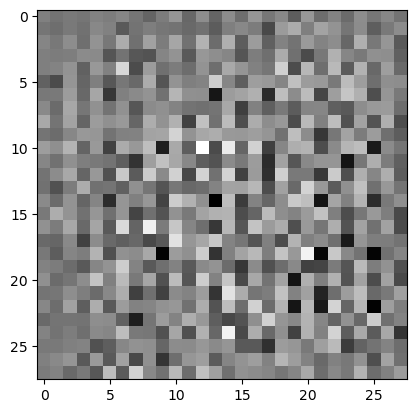

In [108]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

## Construção do discriminador

In [109]:
def cria_discriminador():
    network = tf.keras.Sequential()
    
    #14x14x64
    network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    #7x7x128
    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    
    network.summary()
    return network
    

In [110]:
discriminador = cria_discriminador()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [111]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_4_input')>

In [112]:
discriminador(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00144535]], dtype=float32)>

## Cálculo do erro do gerador e do discriminador

In [113]:
#logits é a saída bruta da rede neural, sem nenhuma função de ativação
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [114]:
def discriminador_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [115]:
def gerador_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [116]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Treinamento da GAN e visualização dos resultados

In [117]:
epocas = 100
dimensao_ruido = 100 #número de números aleatórios que serão gerados
numero_imagens = 16 #16 novas imagens serão geradas no treinamento

In [118]:
batch_size, dimensao_ruido

(256, 100)

In [119]:
@tf.function
def treinamento(imagens):
    ruido = tf.random.normal([batch_size, dimensao_ruido])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        imagens_geradas = gerador(ruido, training=True)
        
        expected_output = discriminador(imagens, training=True)
        fake_output = discriminador(imagens_geradas, training=True)
        
        gen_loss = gerador_loss(fake_output)
        disc_loss = discriminador_loss(expected_output, fake_output)
        
    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)
    
    gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [120]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [121]:
def treina_gan(dataset, epocas, imagens_teste):
    for epoca in range(epocas):
        for imagem_batch in dataset:
            #print(imagem_batch.shape)
            treinamento(imagem_batch)
    
    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(imagens_geradas.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.show()
        

In [ ]:
treina_gan(X_treinamento, epocas, imagens_teste)